In [1]:
import MyLibrary.RayTransform as RT
import MyLibrary.BHcorrection as BHC
import MyLibrary.phantom as ph

import numpy as np
import matplotlib.pyplot as plt

## Beam-hardening

### Monochromatic source 

The variation in intensity for an incident beam of intensity $\Phi_{0,E}$ after crossing the material on length $dx$ is given by 
$$
d\Phi_E = - f_{E} \Phi_{0,E} dx
$$
with $f_{E}$ the energy dependant linear attenuation coefficient. For monochromatic radiation (energy $E_0$), this leads after integration to the well-known Beer-Lambert law which describes the variation of the intensity of a beam crossing a medium of attenuation $f_{E_0}$ along the straight lines $L$
$$
\Phi(L) = \Phi_0 e^{-\int_L f_{E_0}(x)dx}.
$$ 
Denoting by $L(\mathbf{x},\theta) = \{\mathbf{x}+t \theta, t\in\mathbb{R}^+\}$ the straight line starting at $\mathbf{x}\in \mathbb{R}^3$ with direction $\theta \in S^2$, the measure of the attenuated beam for monochromatic radiation delivers the well-known Ray transform $\mathcal{P}$
$$
\ln\frac{\Phi_0}{\Phi(\mathbf{x},\theta)} = \int_{0}^\infty f_{E_0}(\mathbf{x}+t \theta)dt =: \mathcal{P}f_{E_0}(\mathbf{x},\theta).
$$

### Polychromatic source

When the radiation is polychromatic, the variation in intensity for an incident beam of intensity $\Phi_{0,E}$ after crossing the material on length $dx$ is given by 
$$
d\Phi_E = - f_{E} \Phi_{0,E} dx
$$
with $f_{E}$ the energy dependent linear attenuation coefficient. For polychromatic radiation (energy domain $\mathbb{E}=[E_m,E_M]$), the linearity of the model does not hold anymore due to the energy dependency of the attenuation. Integrating over the energy, we obtain the beam-hardening formula,
$$
\frac{\Phi(\mathbf{x},\theta)}{\Phi_0} = \int_\mathbb{E} T(E) e^{-\int_{0}^\infty f_{E_0}(\mathbf{x}+t \theta)dt} dE = \int_\mathbb{E} T(E) e^{-\mathcal{P} f_{E}(\mathbf{x},\theta)} dE
$$
with $T(E)$ the normalized spectrum taking into account the response of the detector. As a consequence, the modeling based on the Ray/Radon transform stops to hold for a polychromatic source.

A "toy" spectrum is built below. 

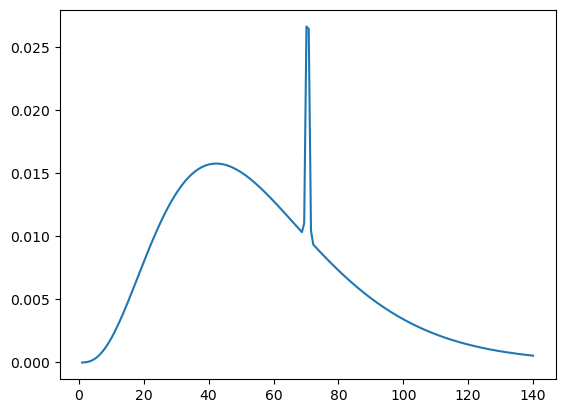

In [2]:
#Spectrum
Emin, Emax = (1,140) #keV

E = np.linspace(Emin,Emax,200)
iE = 1/E**3
dE = E [2]-E[1]
E0 = Emin + 1/2*(Emax-Emin)
s0 = (Emax-Emin)/240


x = E/Emax*10
k = int(x[0] + 2)
T_E = (x-x[0])*(x**k/np.math.factorial(k)*np.exp(-x)) +np.exp(-(E-E0)**2/s0**2)
T_E = T_E/(dE*np.sum(T_E))

plt.figure()
plt.plot(E,T_E)
plt.show()

From Stonestrom et al., the dependency regarding the energy of the attenuation coefficient can be approximated by
\begin{equation}\label{eq:stonestrom}
f_E(\mathbf{x}) = E^{-3} f_1(\mathbf{x}) + C(E) f_2(\mathbf{x})
\end{equation}
with $C(E)$ the Klein-Nishina function and $f_1,f_2$ two characteristic maps  of the attenuating medium. The first part describes the effect of photoelectric absorption whereas the second one gives the attenuation due to Compton scattering.

A toy example is given below.

In [3]:
#Materials and object
dict_materials = {'air':{'a1' : 10, 'a2' : 10**(-3)},
                  'bone':{'a1' : 51200, 'a2' : 0.2835},
                  'iron':{'a1' : 1400000, 'a2' : 1.4},
                  'brain':{'a1' : 4792, 'a2' : 0.1694}}

obj = 'cylinder' #'Shepp-Logan'  
width_in_cm = 30
N    = 101
f0 = np.zeros((N,N))

if obj == 'Shepp-Logan':
    material = 'brain'
    absorption_coef = dict_materials[material]['a1']
    diffusion_coef = dict_materials[material]['a2']
    f0 = ph.phantom(N, "Shepp-Logan")*width_in_cm/N
elif obj == 'cylinder':
    material = 'bone'
    absorption_coef = dict_materials[material]['a1']
    diffusion_coef = dict_materials[material]['a2']
    X,Y = np.meshgrid(np.arange(0,N),np.arange(0,N))
    r1 = 0.4*N
    r2 = 0.05*N
    f0[(X-int((N+1)/2))**2 + (Y-int((N+1)/2))**2 < r1**2] = width_in_cm/N
    f0[(X-int((N+1)/2))**2 + (Y-int((N+1)/2))**2 < r2**2] = 0

Synthetic CT-data can be built using the Beam-hardening formula as in the following example. The parallel geometry and the Radon transform are chosen.

In [4]:
#CT Parameters
modality = 'fanbeam-plane'
Ndetector, Nrota = (2*N+1,N)
center    = [int((N+1)/2),int((N+1)/2)]
distOS = N 
distOD = N 
widthD = 2*N
param_detector   = np.arange(0,widthD,widthD/Ndetector) - widthD/2 
param_rota = 2*np.pi*np.arange(0,Nrota)/(Nrota-1) 
parameters = (param_detector,param_rota,N,center,distOS,distOD)

Xplane = RT.RayTransform(parameters,modality=modality)
Xplane.computeProjectionMatrix(method='pixel')
g_test = Xplane.getData(f0)

Projection Matrix: [##########]100%  Time elapsed: 3.9 seconds


In [5]:
#Generate Data    
C_E    = BHC.DiffusionCS(E)
g_diff = diffusion_coef * g_test
g_abs  = absorption_coef * g_test
g_bh   = np.zeros((Ndetector,Nrota)) 

for i in range(Ndetector):
    for j in range(Nrota):
        g_bh[i,j] = dE*np.sum(T_E*np.exp(-(g_abs[i,j]*iE+C_E*g_diff[i,j])))

### A model for correction 


In practice, $C(E)$ varies only a little due to the size and position of the X-ray energy range. This is why, to simplify the algebra, we consider in our study $C(E)$ to be a constant $a$. This approximation is crucial because it enables to rewrite the beam-hardening phenomenon as
$$
B(\mathcal{P}f_1,\mathcal{P}f_2)(\mathbf{x},\theta) := e^{-a \mathcal{P}f_2(\mathbf{x},\theta)}\int_0^\infty T(E) e^{- \mathcal{P}f_1(\mathbf{x},\theta)/E^{3}} dE =:  e^{-a \mathcal{P}f_2(\mathbf{x},\theta)} P(\mathcal{P}f_1(\mathbf{x},\theta)) =: e^{-g_{BH}}(\mathbf{x},\theta)
$$
with
$$
P(z) := \int_0^\infty T(E) e^{-z/E^3} dE.
$$
The previous decomposition of the function $B(\cdot)$ shows that the strategy to compute a good approximation of the beam-hardening is to design the suited representation for the polychromatic part $P(z)$. Assuming to know the function $T(E)$, we propose to approximate $P(z)$ by 
$$
\tilde{P}(z) = \left(1+bz\right)^{-c}, \ b,c >0.
$$ 
The estimation of parameters $b$ and $c$ can be performed using a Gauss-Newton algorithm or a Levenberg-Marquardt algorithm for a more robust convergence. 

These approximations on the polychromatic part and on the monochromatic part lead to approximate the whole data by 
$$
-\ln (B(\mathcal{P}f_1,\mathcal{P}f_2)) \approx a \mathcal{P}f_2 + c \ln\left(1+b\mathcal{P}f_1 \right).
$$
Without more prior information about $\mathcal{P}f_1$ and $\mathcal{P}f_2$, this formula does not provide a unique solution to reverse the effect of beam-hardening but enables a simpler interpretation. However, if we consider homogeneous objects, the formula becomes invertible.


#### Inversion for homogeneous objects

In the case of homogeneous objects the functions $f_1$ and $f_2$ are constant with respective values $a_1,a_2>0$, i.e.
\begin{equation}
f_E(\mathbf{x}) = (a_1 E^{-3} + a_2 C(E)) f(\mathbf{x})
\end{equation}
with $f(\mathbf{x}) = 1$ if $\mathbf{x}$ belongs to the support of the object, 0 otherwise. 

Putting $\alpha=a_2 a$ and $\beta = a_1 b$, the approximation for the data altered by beam-hardening becomes in the homogeneous case
\begin{equation}\label{eq:approx_BH_homo}
-\ln ({B}(\mathcal{P}f)) \approx \alpha \mathcal{P}f + c \ln\left((1+\beta \mathcal{P}f ) \right) =: \tilde{g}.
\end{equation}
This analytic model presents the advantages of being invertible thanks to the W-Lambert function, $W(x)$. More precisely, we get  
$$
\mathcal{P}f = \frac{\beta c W\left( \frac{\alpha}{\beta c}e^{\frac{\alpha+\beta \tilde{g}}{\beta c}} \right)-\alpha}{\alpha\beta} = \mathcal{C}(\tilde{g},\alpha,\beta,c).
$$
From this model we can therefore correct the effect of beam-hardening and recover the sought-for data $\mathcal{P}f$ in the homogeneous case. By applying the derived inversion formula on the real data $g_{BH}$, we produce corrected data with $g_{corr}  =  \mathcal{C}(g_{BH},\alpha,\beta,c)$.
The image reconstruction consists then to apply a standard reconstruction technique suited to $\mathcal{P}$ on the corrected data $g_{corr}$. 

This is performed by the function <code>BHcorrection()</code> as illustrated below.


In [6]:
#Correction of Beam Hardening    
intervalg = (0.5*absorption_coef*max(g_test.flatten()),absorption_coef*max(g_test.flatten()))
g_corr = BHC.BHcorrection(-np.log(g_bh), T_E, E, intervalg, absorption_coef, diffusion_coef, tau=0.8) 

Parameters of the correction: alpha= 0.28090512246529786  beta= 0.2338726060168978  c= 1.547717462291935


<code>BHcorrection(g_bh,T_E,E,intervalg,absorption_coef,diffusion_coef,tau=0.5,tol=10**(-12))</code> computes the polychromatic function $P()$, the curve fitting and then the correction with the help of the W-Lambert function.

The curve fitting is performed by the Levenberg-Marquardt algorithm via <code>params = LM(P,x,p0,tol)</code> where 
* P denotes the polychromatic part computed from the spectrum $T_E$. 
* $x$ denotes the variable of integration and contains 100 points equally distributed on the interval <code>intervalg</code> given as input of <code>BHcorrection()</code>. For lower energies or extremly dense materials, the range of this variable can be huge. In that case, it can be important to increase the lower bound of <code>intervalg</code> in order to focus on the correction of the higher intensities which are affected the most by beam-hardening. 
* p0 is an initial value for the parameters b and c. 
* tol stands for the tolerance for convergence.
    
The correction is then performed by <code>EvalCorrection(g, alpha, beta, c)</code> where g stands for the CT-data and 
* <code>alpha</code> = $(C_E[0]+$<code>tau</code>$*(C_E[-1]-C_E[0]))$*<code>diffusion_coef</code> with <code>tau</code> given as input of <code>BHcorrection()</code>. Since the approximation of the diffusion coefficient is more difficult for lower energies, this parameter helps to control the contribution of the monochromatic part of the CT-data in the correction. 
* <code>beta</code> = <code>absorption_coef</code>*<code>params[0]</code>
* <code>c</code> = <code>params[1]</code>

It is of course possible to use these functions directly instead of <code>BHcorrection()</code>.

Standard reconstruction approaches such as the FBP can then be applied.

In [7]:
#Reconstructions
f_fbp  = Xplane.ApproximateInverseRT(g_test,gamma=param_detector[1]-param_detector[0])
f_corr = Xplane.ApproximateInverseRT(g_corr,gamma=param_detector[1]-param_detector[0])
f_bh   = Xplane.ApproximateInverseRT(-np.log(g_bh),gamma=param_detector[1]-param_detector[0])

ApproxInverse: [##########]100%  Time elapsed: 10.9 seconds
ApproxInverse: [##########]100%  Time elapsed: 20.8 seconds
ApproxInverse: [##########]100%  Time elapsed: 23.1 seconds


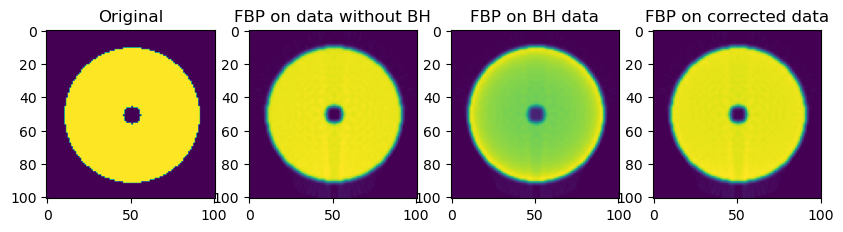

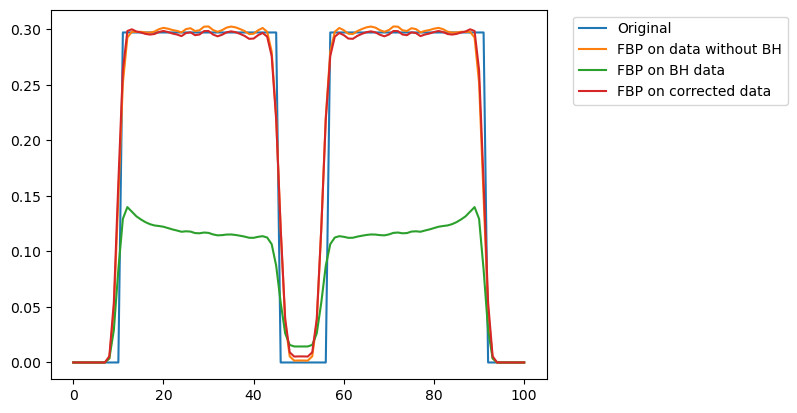

In [8]:
fig, axs = plt.subplots(1,4, num=4)
fig.set_size_inches(10,6)
axs[0].imshow(f0)
axs[0].set_title('Original')
axs[1].imshow(f_fbp)
axs[1].set_title('FBP on data without BH')
axs[2].imshow(f_bh)
axs[2].set_title('FBP on BH data')
axs[3].imshow(f_corr)
axs[3].set_title('FBP on corrected data')
plt.show()

plt.figure(5)
plt.plot(f0[int((N+1)/2),:],label='Original')
plt.plot(f_fbp[int((N+1)/2),:],label='FBP on data without BH')
plt.plot(f_bh[int((N+1)/2),:],label='FBP on BH data')
plt.plot(f_corr[int((N+1)/2),:],label='FBP on corrected data')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()